In [ ]:
# Base Libraries
import os
import re

# Scientific libraries
import pandas as pd
import numpy as np
from pandas.core.interchange.dataframe_protocol import DataFrame
from scipy.stats import alpha
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visual libraries
import seaborn as sns
from seaborn import objects as so
import matplotlib.pyplot as plt
from sklearn.utils.estimator_checks import estimator_checks_generator

print("Set up complete")

# 1. Accoustic Data Preparation

In [ ]:
procDataPath = "C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/processed_AllFishCombined_unfiltered.csv"
proc_data = pd.read_csv(procDataPath, parse_dates=True)

# procAnaPath = "C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/processed_AnalysisData.csv"
# proc_ana = pd.read_csv(procAnaPath, parse_dates=True)
print("Reading complete")

In [3]:
## Subset Training, Testing, and Validation Data
## Prefixes
burbotPr = "BUR"
lakeTroutPr = "LT"
lakeWhiteFishPr = "LWF"
smallMouthBassPr = "SMB"

## Generate the fishNum
def makeFishNum(prefix, interval):
    """
    Computes an array of fish numbers, in format like "LWF001", "LWF012"
    :param prefix: a string of character in length 2 or 3, all capitalized
    :param interval: a list of integers, the fish number in 00X or 0XX format
    :return: a list of strings that represent fish numbers, count from 001 to 00n
    """
    fishNum = [prefix + (3-len(str(c)))*"0" + str(c) for c in interval]
    return fishNum

In [14]:
## Training
burbotNum = makeFishNum("BUR", list(range(1, 2)))
lakeTroutNum = makeFishNum("LT", list(range(1, 13)))
lakeWhiteFishNum = makeFishNum("LWF", list(range(1, 9)))
smallMouthBassNum = makeFishNum("SMB", list(range(1, 9)))

## Training indices
trainInd = burbotNum + lakeTroutNum + lakeWhiteFishNum + smallMouthBassNum

In [15]:
# Validation
burbotNum = makeFishNum("BUR", list(range(2, 3)))
lakeTroutNum = makeFishNum("LT", list(range(13, 18)))
lakeWhiteFishNum = makeFishNum("LWF", list(range(9, 11)))
smallMouthBassNum = makeFishNum("SMB", list(range(10, 13)))

## Training indices
validationInd = burbotNum + lakeTroutNum + lakeWhiteFishNum + smallMouthBassNum

In [16]:
# Test
burbotNum = makeFishNum("BUR", list(range(3, 4)))
lakeTroutNum = makeFishNum("LT", list(range(18, 22)))
lakeWhiteFishNum = makeFishNum("LWF", list(range(11, 14)))
smallMouthBassNum = makeFishNum("SMB", list(range(13, 16)))

## Test indices
TestInd = burbotNum + lakeTroutNum + lakeWhiteFishNum + smallMouthBassNum

In [17]:
## Extract hydroaccoustic columns
allFreq = [col for col in proc_data.columns if re.match(r'^F\d+', col)]
requiredColumns = ['fishNum','species'] + allFreq

## Subset the data into trianing, validation, and test
trainData = proc_data.loc[proc_data["fishNum"].isin(trainInd), requiredColumns] # Training data
validationData = proc_data.loc[proc_data["fishNum"].isin(validationInd), requiredColumns] # Validation data
testData = proc_data.loc[proc_data["fishNum"].isin(TestInd), requiredColumns] # Test data

In [18]:
## Save the training, validation, Test Set to csv
trainData.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/trainData.csv")
trainData.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/validationData.csv")
testData.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/testData.csv")

In [64]:
## Compute mean value of each frequency by fishNum
edaFreqMean = trainData.drop(columns = "species").groupby(['fishNum']).mean().reset_index()
edaFreqMean.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/edaFreqMean.csv")

validationFreqMean = validationData.drop(columns = "species").groupby(['fishNum']).mean().reset_index()
validationFreqMean.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/validationFreMean.csv")

testFreqMean = testData.drop(columns = "species").groupby(['fishNum']).mean().reset_index()
testFreqMean.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/testFreqMean.csv")

In [107]:
edaFreqMean['species'] = trainData[['fishNum', 'species']].groupby("fishNum").first()['species'].tolist()
edaFreqMean['species']

0             burbot
1          lakeTrout
2          lakeTrout
3          lakeTrout
4          lakeTrout
5          lakeTrout
6          lakeTrout
7          lakeTrout
8          lakeTrout
9          lakeTrout
10         lakeTrout
11         lakeTrout
12         lakeTrout
13     lakeWhitefish
14     lakeWhitefish
15     lakeWhitefish
16     lakeWhitefish
17     lakeWhitefish
18     lakeWhitefish
19     lakeWhitefish
20    smallmouthBass
21    smallmouthBass
22    smallmouthBass
23    smallmouthBass
24    smallmouthBass
25    smallmouthBass
26    smallmouthBass
27    smallmouthBass
Name: species, dtype: object

In [109]:
edaFreqSD = trainData.drop(columns = "species").groupby(['fishNum']).std().reset_index()
edaFreqSD['species'] = trainData[['fishNum', 'species']].groupby("fishNum").first()['species'].tolist()

# 2. Physical Data Wrangling

In [36]:
physicalVar = ["species", "sex", "totalLength", "forkLength", "weight",
            "girth", "dorsoLatHeight", "mat", "airbladderTotalLength", 
            "airBladderWidth", "airbladderWeight", "airBladderWeightCond"]
edaPhy = proc_data[["fishNum"] + physicalVar]

## Renaming airBladder variables
edaPhy.rename({"airbladderTotalLength":"abLen", 
               "airBladderWidth":"abWidth", 
               "airbladderWeight":"abWeight", 
               "airBladderWeightCond":"abWeightCond"}, 
               axis=1, inplace=True)

C:\Users\86139\AppData\Local\Temp\ipykernel_9128\2523490145.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edaPhy.rename({"airbladderTotalLength":"abLen",


In [38]:
edaPhy = edaPhy.groupby("fishNum").first().reset_index()

# 3. Data Visualization

C:\Users\86139\AppData\Local\Temp\ipykernel_9128\2860150619.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  edaNullSmry = trainData.drop(columns = "species").groupby("fishNum").apply(lambda x: x.isnull().sum())


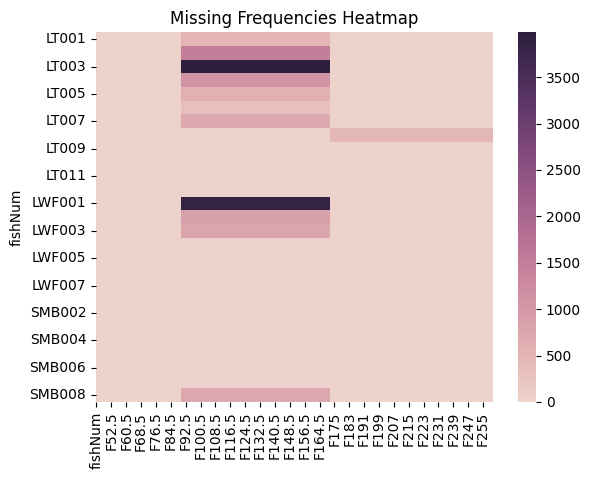

In [29]:
## Visualize missing values using heatmap
edaNullSmry = trainData.drop(columns = "species").groupby("fishNum").apply(lambda x: x.isnull().sum())

sns.heatmap(edaNullSmry[1:], 
            cmap=sns.cubehelix_palette(as_cmap=True), 
            linewidth=0)
plt.title("Missing Frequencies Heatmap")
plt.show()

In [ ]:
## Plot every Physical variables in a scatter by species, exclude fish with missing values
def catPhy(df, phyVar):
    '''
    Plot a violin plot of a physical variable, colored by species, and epxort the plot
    :param df: a dataframe that contains the physical variable and species
    :param phyVar: a string, the name of the physical variable
    :return: None
    '''
    sns.catplot(df, x="species", y=phyVar,
                hue = "species",
                palette="bright",
                alpha=0.5,
                kind = "violin")
    plt.title(f"Violin Plot of {phyVar}, Colored by Species")
    plt.xticks(rotation=45)
    # plt.show()
    plt.savefig(f"C:/Users/86139/Desktop/Images/{phyVar}.png")

def multiCatPhy(df, phyVarArray):
    '''
    Plot and export a violin plot of multiple physical variables, colored by species
    :param df: a dataframe that contains the physical variable and species
    :param phyVarArray: a list of strings, the name of the physical variable
    :return
    '''
    for phyVar in phyVarArray:
        catPhy(df, phyVar)
    return None

In [42]:
physicalVar

['sex',
 'totalLength',
 'forkLength',
 'weight',
 'girth',
 'dorsoLatHeight',
 'mat',
 'abLen',
 'abWidth',
 'abWeight',
 'abWeightCond']

C:\Users\86139\AppData\Local\Temp\ipykernel_9128\2135152087.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Tilt x-axis labels by 45 degrees
C:\Users\86139\AppData\Local\Temp\ipykernel_9128\2135152087.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Tilt x-axis labels by 45 degrees
C:\Users\86139\AppData\Local\Temp\ipykernel_9128\2135152087.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Tilt x-axis labels by 45 degrees
C:\Users\86139\AppData\Local\Temp\ipykernel_9128\2135152087.py:14: UserWarning: set_ticklabels() should only 

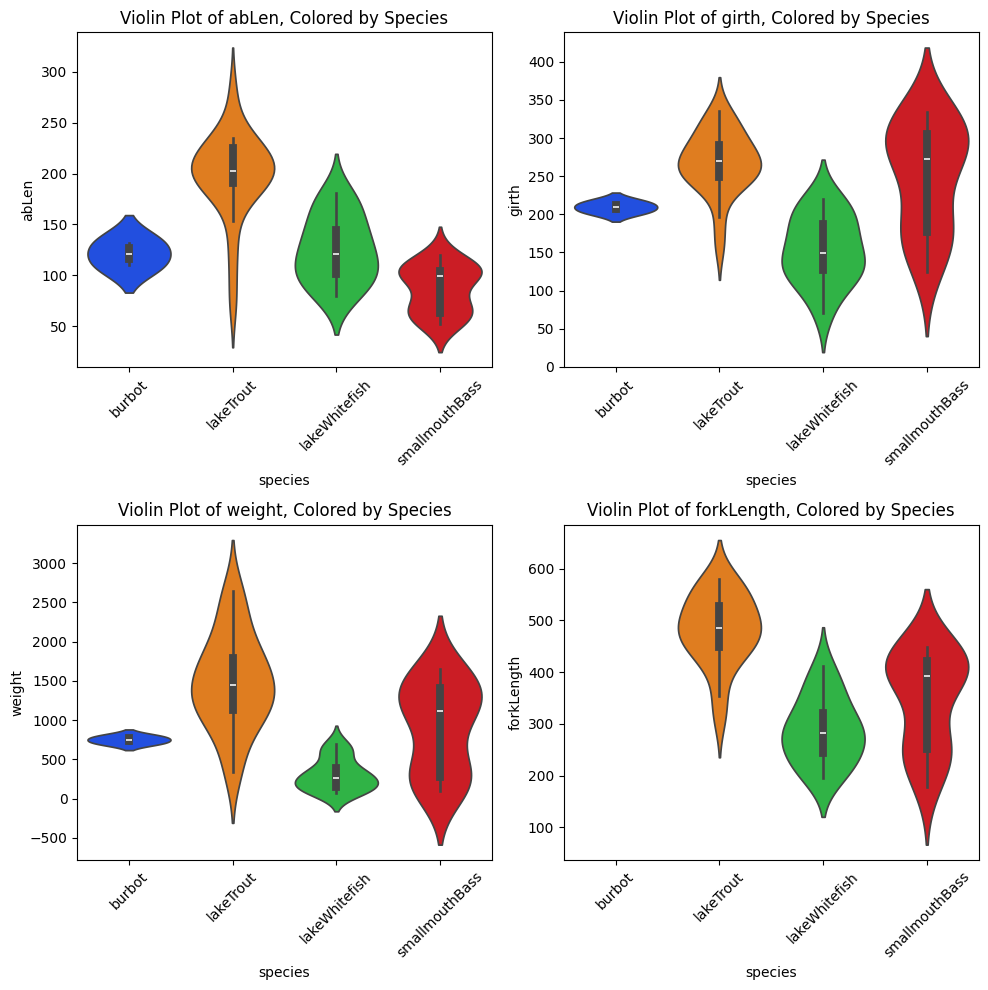

In [43]:
## Save differential geometrics
phyDiff = ["abLen", "girth", "weight", "forkLength"]
f, axes = plt.subplots(2, 2, figsize=(10, 10))  # You can adjust the figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

i = 0
for phyVar in phyDiff:
    sns.violinplot(data=edaPhy, x="species", y=phyVar, ax=axes[i],
                   hue="species",
                   palette="bright")
    axes[i].set_title(f"Violin Plot of {phyVar}, Colored by Species")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Tilt x-axis labels by 45 degrees
    i += 1

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
edaFreqMeanLong = pd.melt(edaFreqMean[["fishNum", "species"]+allFreq], id_vars = ["fishNum", "species"])
edaFreqMeanLong.rename({"variable": "Freq", "value": "TS"}, axis=1, inplace=True)
edaFreqMeanLong["Freq"] = edaFreqMeanLong["Freq"].str.extract(r'(\d+)', expand=False).astype(int)
edaFreqMeanLong.groupby("species").median("TS")
edaFreqMeanLong

,fishNum,species,Freq,TS
0,BUR001,burbot,45,-46.479146
1,LT001,lakeTrout,45,-46.645407
2,LT002,lakeTrout,45,-47.560521
3,LT003,lakeTrout,45,-46.168306
4,LT004,lakeTrout,45,-40.730473
...,...,...,...,...
11923,SMB004,smallmouthBass,260,-38.470123
11924,SMB005,smallmouthBass,260,-32.969351
11925,SMB006,smallmouthBass,260,-34.342871
11926,SMB007,smallmouthBass,260,-38.500364


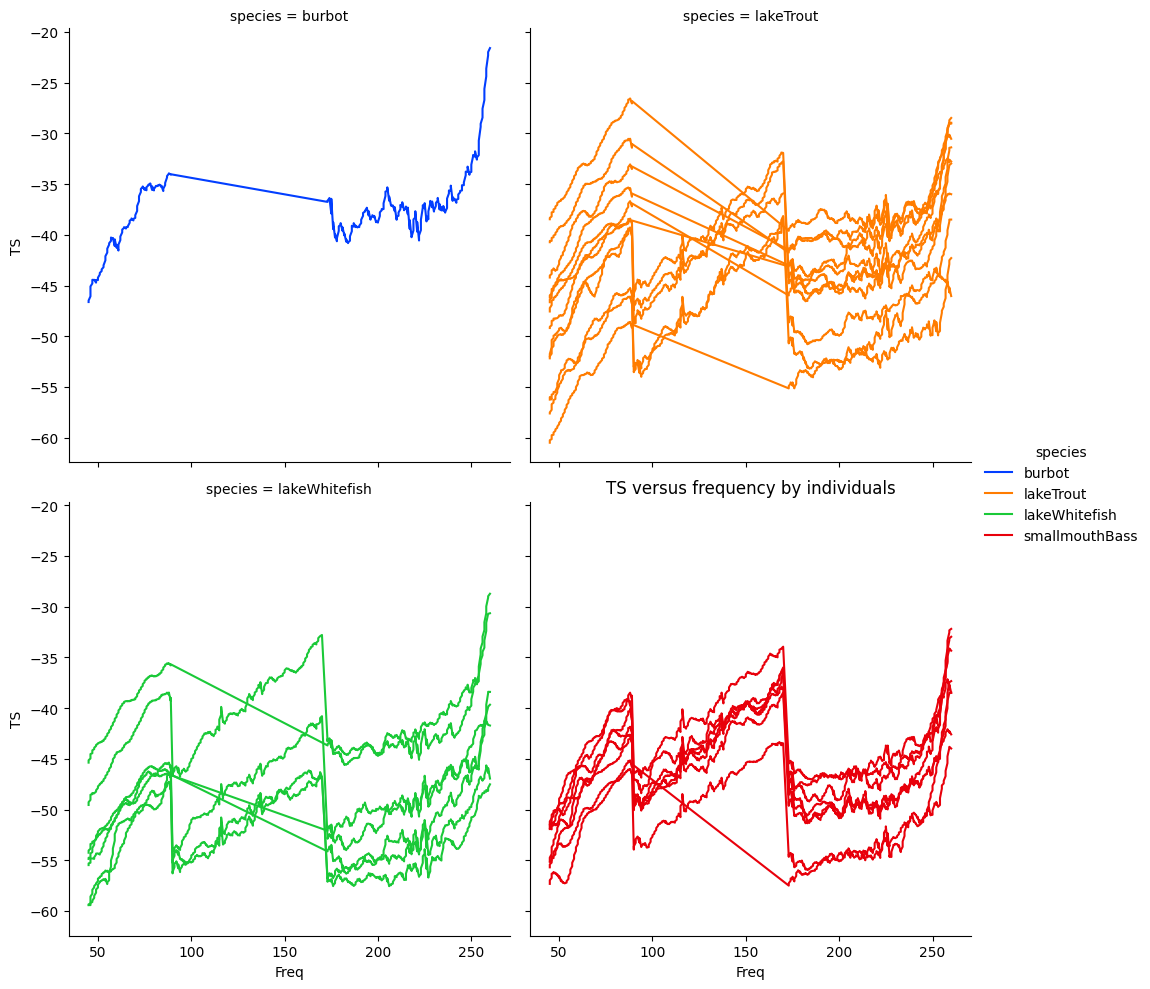

In [112]:
## Spaghetti plot for sonar frequency time
# Per each species, plot their line chart of relationships between TS and frequency, assign error bars.
# Drop rows with NA values in 'TS' column
# edaFreqMeanLong = edaFreqMeanLong.dropna(subset=['TS'])
sns.relplot(edaFreqMeanLong,  kind="line",
            x = "Freq", y="TS", units = "fishNum",
            col = "species", col_wrap = 2, hue = "species",
            palette="bright", estimator=None)
# Add titles and labels
plt.title('TS versus frequency by individuals')
plt.xlabel('Freq')
plt.ylabel('TS')
# plt.legend(loc='top')

# Show the plot
plt.show()

In [131]:
edaFreqSDLong = pd.melt(edaFreqSD[["fishNum", "species"]+allFreq], id_vars = ["fishNum", "species"])
edaFreqSDLong.rename({"variable": "Freq", "value": "TS"}, axis=1, inplace=True)
edaFreqSDLong["Freq"] = edaFreqSDLong["Freq"].str.extract(r'(\d+)', expand=False).astype(int)
edaFreqSDLong.groupby("species").median("TS")
edaFreqSDLong

,fishNum,species,Freq,TS
0,BUR001,burbot,45,7.775138
1,LT001,lakeTrout,45,7.628906
2,LT002,lakeTrout,45,7.332283
3,LT003,lakeTrout,45,8.654434
4,LT004,lakeTrout,45,5.603666
...,...,...,...,...
11923,SMB004,smallmouthBass,260,8.308847
11924,SMB005,smallmouthBass,260,9.199942
11925,SMB006,smallmouthBass,260,7.995150
11926,SMB007,smallmouthBass,260,7.197863


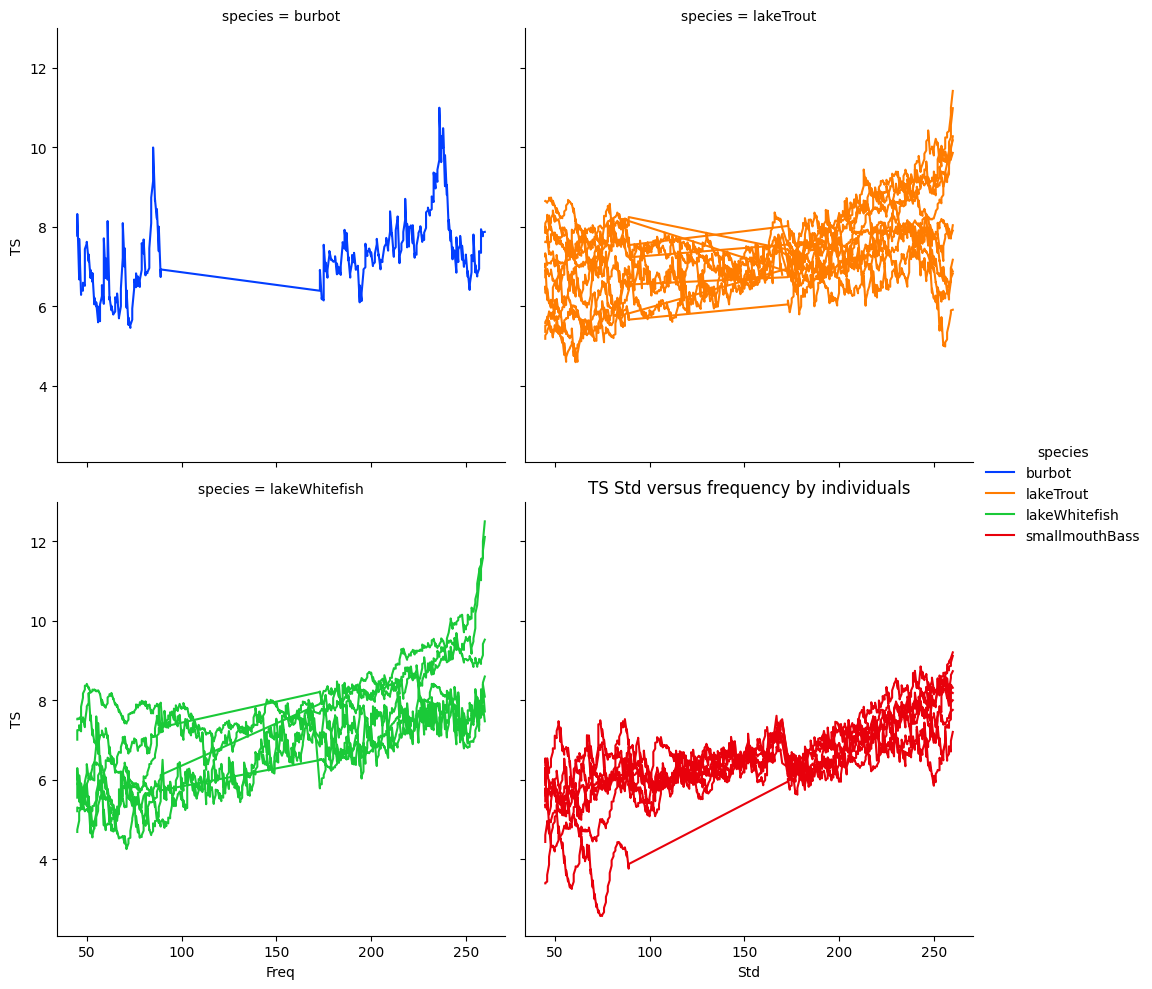

In [132]:
## Spaghetti plot for std of TS against frequency
# Per each species, plot their line chart of relationships between TS and frequency, assign error bars.
# Drop rows with NA values in 'TS' column
# edaFreqMeanLong = edaFreqMeanLong.dropna(subset=['TS'])
sns.relplot(edaFreqSDLong,  kind="line",
            x = "Freq", y="TS", units = "fishNum",
            col = "species", col_wrap = 2, hue = "species",
            palette="bright", estimator=None)
# Add titles and labels
plt.title('TS Std versus frequency by individuals')
plt.xlabel('Std')
plt.ylabel('TS')

# Show the plot
plt.show()

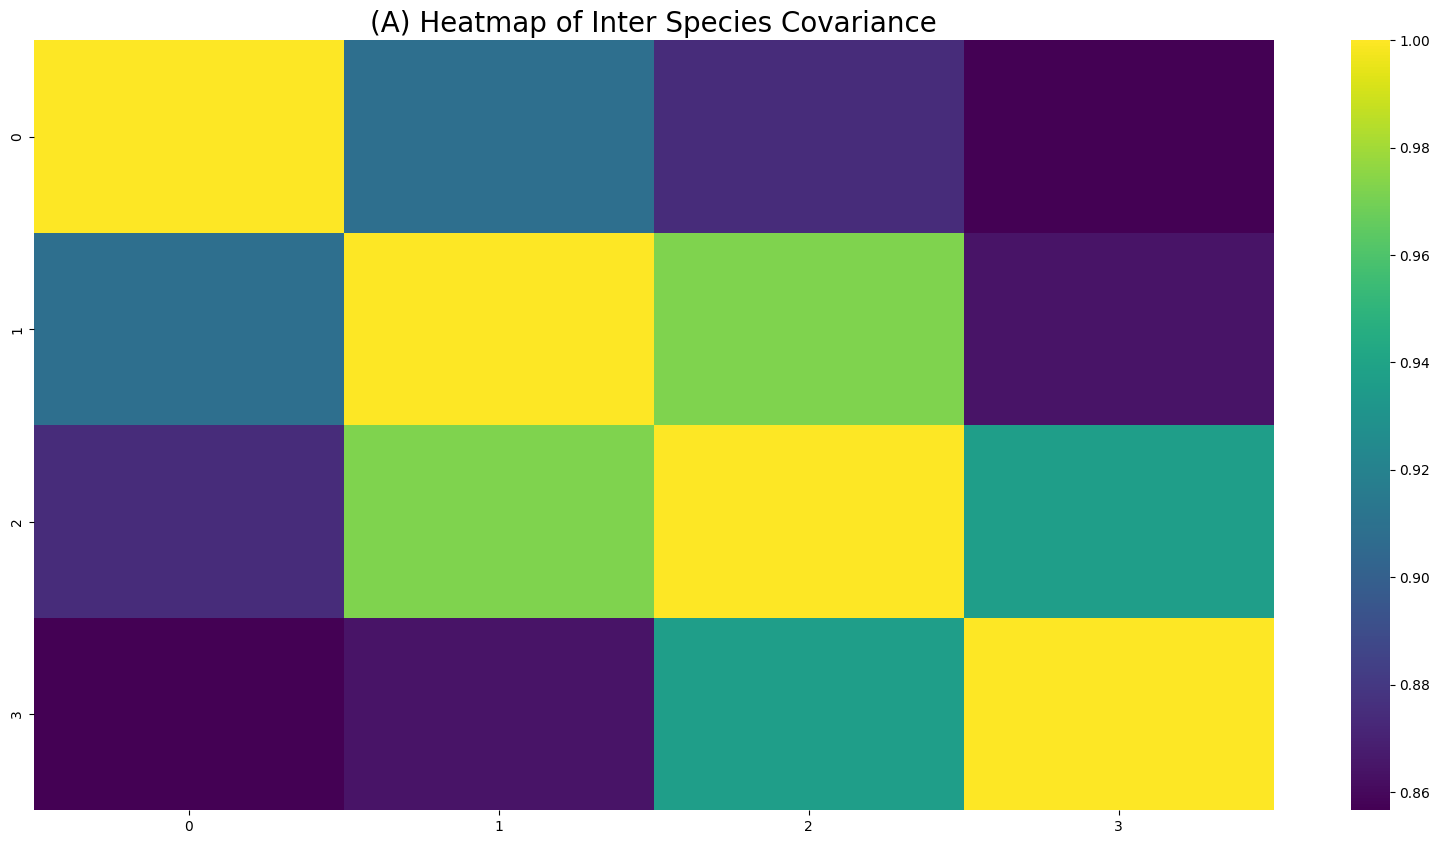

In [117]:
## Frequency correlation based on species-wide average TS

edaFreqBySpecies = trainData[["species"] + allFreq].groupby("species").mean().reset_index()
interSpeciesCovariance = edaFreqBySpecies[allFreq].T.corr()

plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
sns.heatmap(interSpeciesCovariance, cmap="viridis")
plt.title("(A) Heatmap of Inter Species Covariance", fontsize=20)
plt.show()

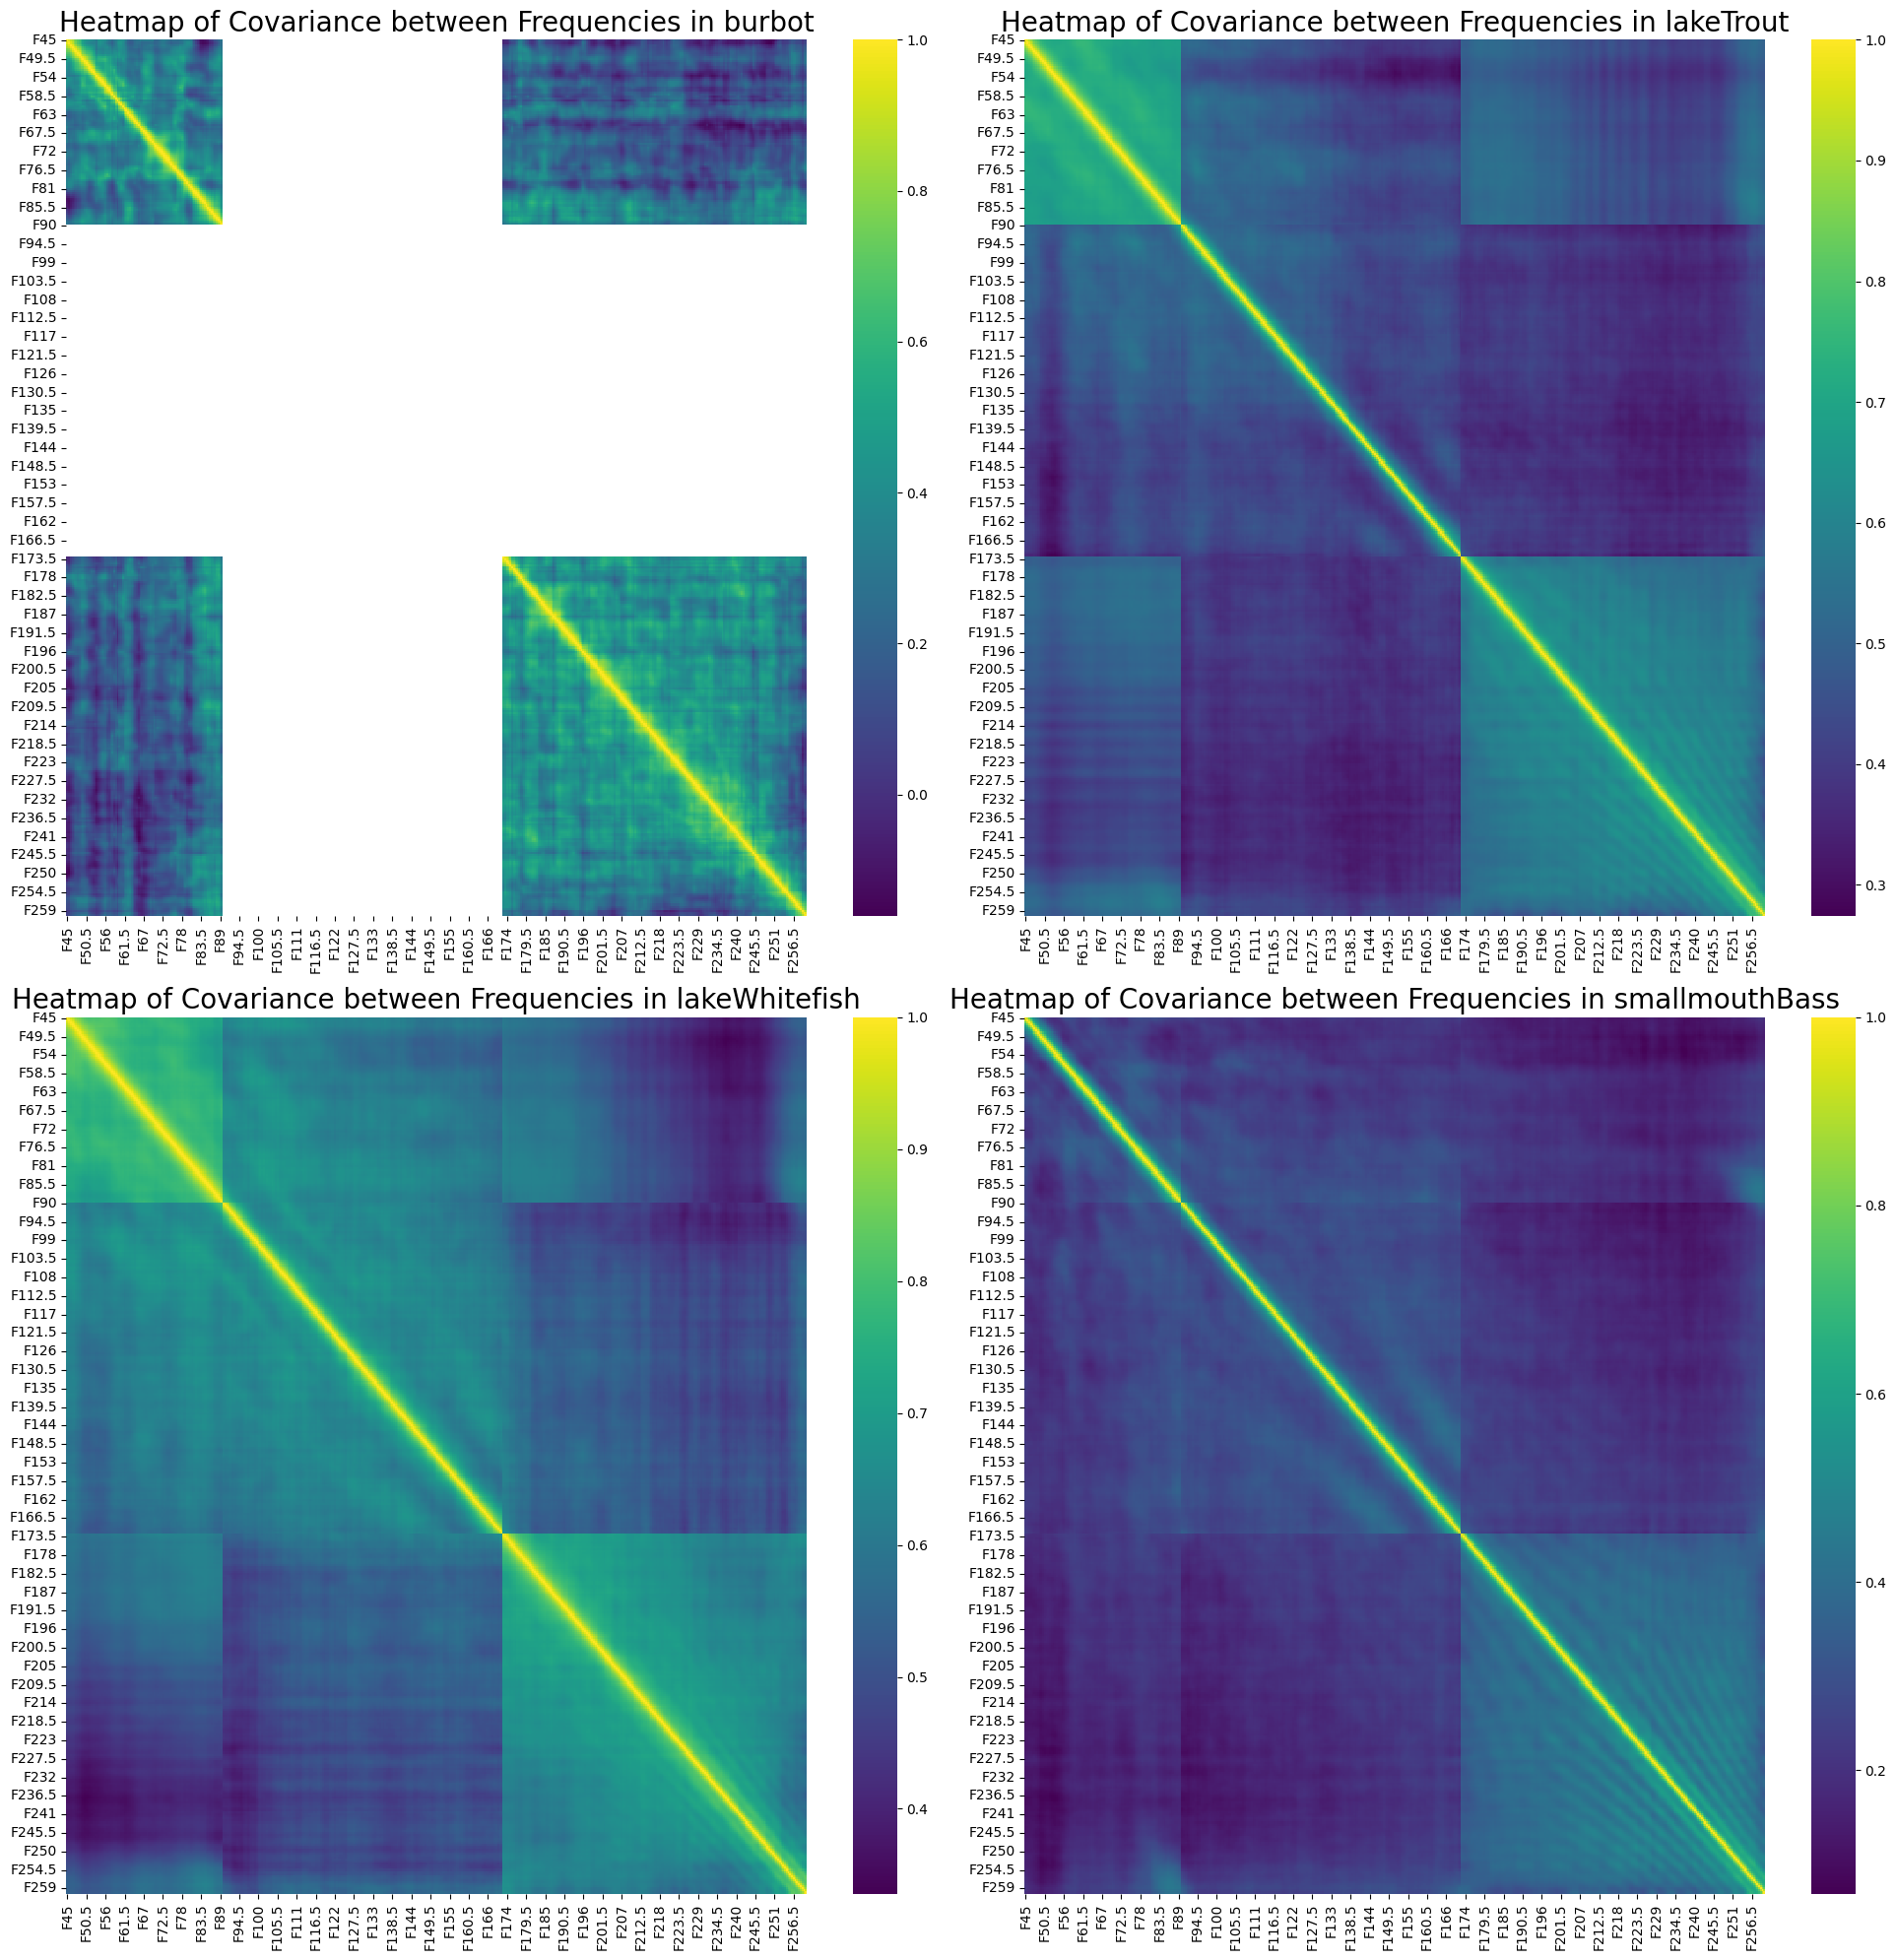

In [119]:
## Frequency correlation within each fish species

freqGroupbySpecies = trainData[["species"] + allFreq].groupby("species")

fig, ax = plt.subplots(2,2, figsize=(20, 20))
i = 0
for name, group in freqGroupbySpecies:
    groupFreqCorr = group[allFreq].corr()
    sns.heatmap(groupFreqCorr, cmap="viridis", ax = ax[i//2, i%2])
    ax[i//2, i%2].set_title(f"Heatmap of Covariance between Frequencies in {name}", fontsize=20)
    i += 1

fig.tight_layout()
plt.show()

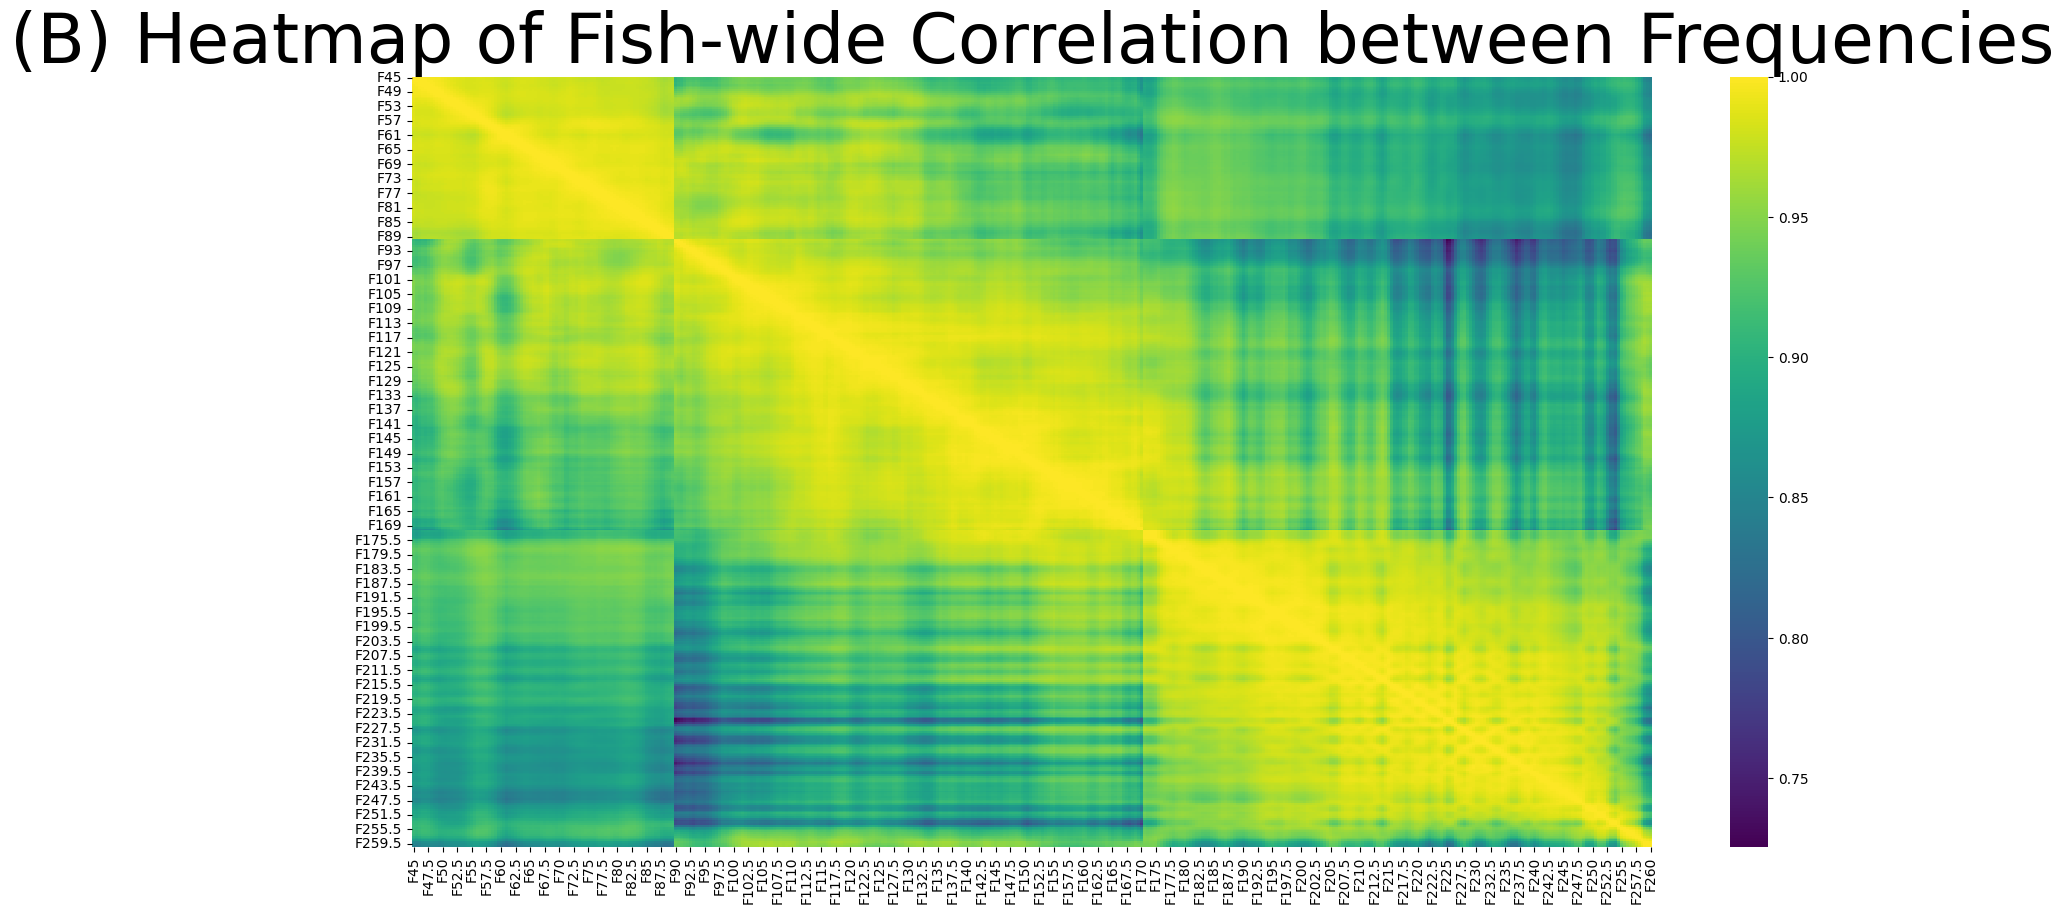

In [125]:
## Frequency correlation with all species combined, based on fish-wide average TS
interFreqCovariance = edaFreqMean.drop(columns=["fishNum", "species"]).corr()

plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
sns.heatmap(interFreqCovariance, cmap="viridis")
plt.title("(B) Heatmap of Fish-wide Correlation between Frequencies", fontsize=50)
plt.show()

# 4. Global PCA

In [126]:
## Drop NAs in accoustic data
## Remove LT008
edaFreqMean.set_index("fishNum", inplace=True)
edaFreqMean.drop("LT008", axis=0, inplace = True)
# Remove all columns with any missing values
edaFreqMean.dropna(axis=1, how="any", inplace=True)
edaFreqMean

,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,F49.5,...,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260,species
fishNum,,,,,,,,,,,,,,,,,,,,,
BUR001,-46.479146,-46.629557,-46.066176,-45.091633,-44.798135,-44.437357,-44.456649,-44.437115,-44.456290,-44.717498,...,-28.443539,-27.567882,-26.713292,-25.613016,-24.387497,-23.621642,-22.306471,-21.985734,-21.591365,burbot
LT001,-46.645407,-46.367350,-46.199488,-45.653350,-45.463655,-45.166661,-45.074204,-44.997179,-44.868336,-44.747247,...,-32.515203,-32.140573,-31.557621,-30.972239,-30.231923,-29.673079,-29.033348,-28.952772,-28.955729,lakeTrout
LT002,-47.560521,-47.215797,-46.932365,-46.473483,-46.410474,-46.206567,-46.141046,-46.063951,-45.928372,-45.810265,...,-37.507503,-37.102629,-36.608307,-36.339585,-35.996327,-36.046391,-35.933225,-36.000538,-35.998340,lakeTrout
LT003,-46.168306,-45.968098,-45.782728,-45.344954,-45.274179,-45.040486,-44.923072,-44.748890,-44.548537,-44.354827,...,-32.686375,-32.061705,-31.470881,-30.837042,-30.222146,-29.694168,-28.856576,-28.702194,-28.481229,lakeTrout
LT004,-40.730473,-40.601601,-40.601523,-40.309100,-40.244519,-40.078168,-39.976723,-39.825742,-39.626494,-39.494479,...,-31.605860,-31.212022,-30.949060,-30.625302,-30.198328,-30.159049,-30.135791,-30.374540,-30.536444,lakeTrout
LT005,-60.496846,-60.252259,-60.142293,-59.752711,-59.717030,-59.492988,-59.327611,-59.181236,-59.033960,-58.906425,...,-44.419923,-44.419437,-44.427077,-44.630374,-44.598437,-44.986819,-45.202528,-45.680993,-46.040943,lakeTrout
LT006,-38.467984,-38.332608,-38.188313,-37.787999,-37.744940,-37.498326,-37.387439,-37.210920,-37.053602,-36.852407,...,-31.375899,-31.057959,-30.655594,-30.324443,-29.802385,-29.451981,-29.102356,-29.016297,-29.030183,lakeTrout
LT007,-44.213031,-44.013071,-43.864818,-43.497515,-43.414356,-43.311410,-43.464125,-43.561277,-43.450102,-43.243596,...,-33.465612,-33.238753,-32.863688,-32.678450,-32.476953,-32.545077,-32.588351,-32.863067,-32.776063,lakeTrout
LT009,-55.998240,-56.249511,-56.232359,-55.758057,-55.672651,-55.494183,-55.511124,-55.419288,-55.004976,-54.637005,...,-41.943166,-41.688984,-41.277030,-40.596161,-40.004325,-39.561105,-38.702772,-38.499393,-38.499108,lakeTrout


In [128]:
X

,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,F49.5,...,F255.5,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260
fishNum,,,,,,,,,,,,,,,,,,,,,
BUR001,-46.479146,-46.629557,-46.066176,-45.091633,-44.798135,-44.437357,-44.456649,-44.437115,-44.456290,-44.717498,...,-29.060127,-28.443539,-27.567882,-26.713292,-25.613016,-24.387497,-23.621642,-22.306471,-21.985734,-21.591365
LT001,-46.645407,-46.367350,-46.199488,-45.653350,-45.463655,-45.166661,-45.074204,-44.997179,-44.868336,-44.747247,...,-33.118848,-32.515203,-32.140573,-31.557621,-30.972239,-30.231923,-29.673079,-29.033348,-28.952772,-28.955729
LT002,-47.560521,-47.215797,-46.932365,-46.473483,-46.410474,-46.206567,-46.141046,-46.063951,-45.928372,-45.810265,...,-37.753181,-37.507503,-37.102629,-36.608307,-36.339585,-35.996327,-36.046391,-35.933225,-36.000538,-35.998340
LT003,-46.168306,-45.968098,-45.782728,-45.344954,-45.274179,-45.040486,-44.923072,-44.748890,-44.548537,-44.354827,...,-33.244680,-32.686375,-32.061705,-31.470881,-30.837042,-30.222146,-29.694168,-28.856576,-28.702194,-28.481229
LT004,-40.730473,-40.601601,-40.601523,-40.309100,-40.244519,-40.078168,-39.976723,-39.825742,-39.626494,-39.494479,...,-31.923855,-31.605860,-31.212022,-30.949060,-30.625302,-30.198328,-30.159049,-30.135791,-30.374540,-30.536444
LT005,-60.496846,-60.252259,-60.142293,-59.752711,-59.717030,-59.492988,-59.327611,-59.181236,-59.033960,-58.906425,...,-44.351424,-44.419923,-44.419437,-44.427077,-44.630374,-44.598437,-44.986819,-45.202528,-45.680993,-46.040943
LT006,-38.467984,-38.332608,-38.188313,-37.787999,-37.744940,-37.498326,-37.387439,-37.210920,-37.053602,-36.852407,...,-31.669777,-31.375899,-31.057959,-30.655594,-30.324443,-29.802385,-29.451981,-29.102356,-29.016297,-29.030183
LT007,-44.213031,-44.013071,-43.864818,-43.497515,-43.414356,-43.311410,-43.464125,-43.561277,-43.450102,-43.243596,...,-33.626353,-33.465612,-33.238753,-32.863688,-32.678450,-32.476953,-32.545077,-32.588351,-32.863067,-32.776063
LT009,-55.998240,-56.249511,-56.232359,-55.758057,-55.672651,-55.494183,-55.511124,-55.419288,-55.004976,-54.637005,...,-42.197510,-41.943166,-41.688984,-41.277030,-40.596161,-40.004325,-39.561105,-38.702772,-38.499393,-38.499108


In [ ]:
## PCA explain the total variance
X = edaFreqMean.drop(["species"], axis = 1)
X_standardized = StandardScaler().fit(X)
pca = PCA(n_components = X.shape[0], svd_solver = "full")
pca.fit(X_standardized)
V2 =  pca.components_[:2]# the first two principle vectors
Z2 = X @ V2.T # The first two score vectors

KeyError: "['fishNum'] not found in axis"

In [ ]:
# The score vector
Z2.rename(columns = {0: "PC1", 1:"PC2"}, inplace = True)
Z2["Species"] = edaFreqMean.species

In [ ]:
V2Frame = pd.DataFrame(V2.T)
V2Frame["Freq"] = edaFreqMean.columns[:-1].str.extract(r'(\d+)', expand=False)
V2Frame.rename(columns = {0: "PC1", 1: "PC2"}, inplace = True)

In [111]:
V2Frame.Freq = V2Frame.Freq.astype(int)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
## Scree plot
ax1.bar(PVE.Component, PVE.Variance)
ax1.set_title("(A) Proportion of Variance Explained")
ax1.set_xlabel("Number of Component")
ax1.set_ylabel("Proportion")

## Loading Vectors
ax2.plot(V2Frame["Freq"], V2Frame["PC1"], "--", label="PC1")
ax2.plot(V2Frame["Freq"], V2Frame["PC2"], "--", label="PC2")
ax2.set_title("(B) Top 5 Loading Vectors")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Weights")
ax2.legend()

## Biplot
colors = sns.color_palette("Set1", n_colors=4)
zGroup = Z2.groupby('Species')
cmap = dict(zip(Z2.Species.unique(),
                colors))

for name, group in zGroup:
    ax3.scatter(group.PC1, group.PC2, label=name, color=cmap[name])
ax3.legend()
ax3.set_title("(C) Scatter Plot with respect to the Top 2 Principal Components")
ax3.set_xlabel(f"PC1 ({round(PVE.Variance[0]*100, 2)} %)")
ax3.set_ylabel(f"PC2 ({round(PVE.Variance[1]*100, 2)} %)")

plt.tight_layout()
plt.show()

In [ ]:
# Creating the scree plot
# fig, ax = plt.subplots()
plt.figure(figsize = (10,6))
sns.barplot(x='Component', y='Variance', data=PVE[:10], palette='viridis')  # Limiting to the first 10 components
plt.title('Proportion of Variance Explained')
plt.set_xlabel('Principal Component')
plt.set_ylabel('Variance')
plt.yaxis.set_major_locator(plt.MultipleLocator(0.05))
plt.show()

In [ ]:
pveList = pca.explained_variance_ratio_.tolist()

In [ ]:
## Create Biplot
plt.figure(figsize = (10,6))
sns.scatterplot(data = Z2, x='PC1', y='PC2', hue = "Species", palette='bright')  # Limiting to the first 10 components
plt.title('Biplot of Top 2 Principle Components')
plt.xlabel(f'PC 1 {pveList[0]*100:.2f}%')
plt.ylabel(f'PC 2 {pveList[1]*100:.2f}%')
plt.show()
# PVE[:10]

In [ ]:
# Create Pairplot with marginal distribution histograms
V3 = pca.components_[:3,]
Z3 = X @ V3.T
Z2.rename(columns={0: "PC1", 1: "PC2"}, inplace=True)
Z3["Species"] = Z3.index.str.extract(pat=r'([A-Z]+)').squeeze().tolist()

In [ ]:
plt.figure(figsize = (10,10))
sns.pairplot(Z3, hue = "Species", palette='bright')
plt.title('Pairplot for Distributions of Top 3 Score Vectors')
plt.show()

# 5. PCA on Un-averaged TS Data

In [ ]:
def thresholdImpute(df):
    """
    Impute missing values in a DataFrame.
    For each column, if there are more than 50% missing values, drop that column.
    Otherwise, impute the column mean to the missing values.
    Skip columns with no missing values.
    
    :param df: pandas DataFrame
    :return: pandas DataFrame with imputed values
    """
    threshold = 0.5 * len(df)
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count == 0:
            continue
        elif missing_count > threshold:
            df.drop(columns=[col], inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)
    return df

# Example usage
# df_imputed = impute_missing_values(proc_data)

## Group wide PCA
def speciesWidePCA(df, species, freqVar):
    """
    Perform PCA on all individuals in a given species
    :param df: a DataFrame with a column being the fish number and the rest being frequencies
    :param groupVar: a string, the column name of the group variable
    :param freqVar: a list of strings, the column names of the frequencies
    :return: dictionary containing a DataFrame with the first 2 principle components, 
    a list of the explained variance ratio, and the frequency names, and the first 3 principle components
    """
    groupFreq = df.loc[df.species == species, freqVar]
    groupFreq = thresholdImpute(groupFreq)

    groupFreqStandardized = StandardScaler().fit(groupFreq).transform(groupFreq)
    print("Stenadardizer set up")
    pca = PCA(n_components=10, svd_solver="full")
    pca.fit(groupFreqStandardized)

    V3 = pca.components_[:3]  # the first three principle vectors
    propExplained = pca.explained_variance_ratio_

    # Z3 = pd.DataFrame(groupFreq @ V3.T)  # The first three score vectors
    # Z3.rename(columns={0: "PC1", 1: "PC2", 3: "PC3"}, inplace=True)

    return {"PC": V3.T, "Scree": propExplained, "Freq": groupFreq.columns}


In [ ]:
edaFreqRaw= trainData[["fishNum", "species"] + allFreq]

# from sklearn.impute import SimpleImputer

# X = edaFreqRaw.loc[edaFreqRaw.species == "burbot", allFreq]
# X = thresholdImpute(X)

# # X.dropna(axis=1, how="any", inplace=True)
# # X.dropna(axis=0, how="any", inplace=True)

# X_std = StandardScaler().fit(X).transform(X)

# pca = PCA(n_components=10, svd_solver="full")
# pca.fit(X_std).components_

# speciesWidePCA(edaFreqRaw, "lakeWhiteFish", allFreq)

# thresholdImpute()
edaFreqRaw.loc[edaFreqRaw.species == "lakeWhitefish", allFreq]

# edaFreqRaw.species.unique()

In [ ]:
allSpecies = ["burbot", "lakeTrout", "lakeWhitefish", "smallmouthBass"]
listOfPC = pd.DataFrame({"Species": [], "PC1": [], "PC2": [], "PC3": []})
listOfProp = pd.DataFrame({"Species": [], "Proportion": []})
# listOfScore = pd.DataFrame({"Species": [], "Z1": [], "Z2": [], "Z3": []})

for species in allSpecies:
    speciesPCA = speciesWidePCA(edaFreqRaw, species, allFreq)

    pcFrame = pd.DataFrame(speciesPCA["PC"], columns=["PC1", "PC2", "PC3"])
    pcFrame["Species"] = species
    pcFrame["Freq"] = speciesPCA["Freq"]
    listOfPC = pd.concat([listOfPC, pcFrame], axis=0)

    screeFrame = pd.DataFrame(speciesPCA["Scree"], columns=["Proportion"])
    screeFrame["Species"] = species
    screeFrame["Component"] = screeFrame.index + 1
    listOfProp = pd.concat([listOfProp, screeFrame], axis=0)

    
    # scoreFrame = pd.DataFrame(speciesPCA["Score"], columns=["Z1", "Z2", "Z3"])
    # scoreFrame["Species"] = species
    # listOfScore = pd.concat([listOfScore, scoreFrame], axis=0)

In [52]:
listOfPC.Freq = listOfPC.Freq.str.extract(r'(\d+)', expand=False).astype(int)

In [ ]:
listOfProp

In [ ]:
fig, ax1 = plt.subplots(2, 2, figsize=(10, 6))

# Plot the clustered bar plot
sns.barplot(data=listOfProp, x='Component', y='Proportion', hue='Species', palette='bright', ax=ax1[0, 0])
ax1[0, 0].set_title("Proportion of Variance Explained by Species")
ax1[0, 0].set_xlabel("Number of Component")
ax1[0, 0].set_ylabel("Proportion")


# Plot the first component of each species on the second subplot
sns.lineplot(data=listOfPC, x='Freq', y='PC1',
            hue='Species', palette='bright', alpha=0.5,
            ax=ax1[0,1])
ax1[0, 1].set_title("PC1 by Species")
ax1[0, 1].set_xlabel("Freq")
ax1[0, 1].set_ylabel("Loading Vector")
ax1[0, 1].legend()
    

# Plot the 2nd component of each species on the second subplot
sns.lineplot(data=listOfPC, x='Freq', y='PC2',
            hue='Species', palette='bright', alpha=0.5,
            ax=ax1[1, 0])
ax1[1, 0].set_title("PC2 by Species")
ax1[1, 0].set_xlabel("Freq")
ax1[1, 0].set_ylabel("Loading Vector")
ax1[1, 0].legend()


# Plot the 2nd component of each species on the second subplot
sns.lineplot(data=listOfPC, x='Freq', y='PC3',
            hue='Species', palette='bright', alpha=0.5,
            ax=ax1[1, 1])
ax1[1, 1].set_title("PC3 by Species")
ax1[1, 1].set_xlabel("Freq")
ax1[1, 1].set_ylabel("Loading Vector")
ax1[1, 1].legend()


plt.tight_layout()
plt.show()

In [64]:
listOfPC.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/PCbySpecies.csv")
listOfProp.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/PropbySpecies.csv")

In [ ]:
edaFreqMean.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/edaFreqMean.csv")
edaFreqRaw.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/edaFreqRaw.csv")